In [1]:
from sympy import sin, cos, symbols, diff, Matrix, lambdify
from sympy import solve, simplify
from sympy.physics.mechanics import LagrangesMethod, Lagrangian
from sympy.physics.mechanics import ReferenceFrame, Particle, Point
from sympy.physics.mechanics import dynamicsymbols, kinetic_energy
from sympy.physics.mechanics import mprint, mlatex
from sympy import init_printing, init_session
from sympy.physics.vector import init_vprinting
init_vprinting(pretty_print=True)
import numpy as np
from scipy import signal
import control
#https://qiita.com/acela86/items/170dba21021e387dfc89

# 1段振り子

一段振り子の伝達関数をラグランジアンから求める。


まずは、Sympyの準備から。振り子の変数を定義する。

In [2]:
t = symbols("t")
X, x1, f1 = dynamicsymbols("X x1 f1")
m1, c1, k1 = symbols("m1 c1 k1")
l1, g = symbols("l1 g")
w1 = symbols("w1")

質点を定義する。

In [3]:
N = ReferenceFrame("N")

p1 = Point("p1") 
v1 = x1.diff(t)
p1.set_vel(N, v1*N.x)
pa1 = Particle("pa1", p1, m1)

ポテンシャルエネルギーを定義する。

In [4]:
pa1.potential_energy = k1*(x1-X)**2/2 

外力を定義する。

In [5]:
F = c1*(v1)**2/2
fc1 = -F.diff(v1)
fl = [(p1, (f1 + fc1)*N.x)]

ラグランジアンから運動方程式を求める。

In [6]:
L = Lagrangian(N, pa1)
q = Matrix([x1])
LM = LagrangesMethod(L, q, forcelist=fl, frame=N)
eq = LM.form_lagranges_equations()
As, Bs, u = LM.linearize(q_ind=q, qd_ind=q.diff(t), A_and_B=True)#,simplify=True)
eq

⎡        k₁⋅(-2⋅X + 2⋅x₁)             ⎤
⎢c₁⋅x₁̇ + ──────────────── + m₁⋅x₁̈ - f₁⎥
⎣               2                     ⎦

実際の値を代入する。

In [7]:
m1n = 1. #kg
c1n = 0.00005 #
gn = 9.8
l1n = 0.25
w1n = (gn/l1n)**(1/2)
k1n = w1n**2*m1n

As_func = lambdify((m1, c1, k1), As, modules="numpy")
Bs_func = lambdify((m1, k1), Bs, modules="numpy")

A0 = As_func(m1n, c1n, k1n)
B0 = Bs_func(m1n, k1n)
A0

array([[ 0.00e+00,  1.00e+00],
       [-3.92e+01, -5.00e-05]])

状態方程式から伝達関数を求める。そのために、出力項を定義する。

状態変数すべてをとりだしたいので、Cは単位行列にする。
入力は出力に取り出さないのでDはゼロ。

In [8]:
C = np.eye(2)
D = np.zeros((2,2))

Python のControlパッケージをつかって、ABCD行列から求める。

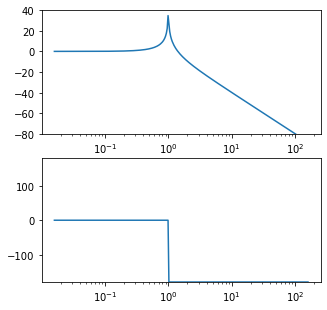

In [9]:
import matplotlib.pyplot as plt
sys = control.ss(A0,B0,C,D)
mag,phase,omega = sys.freqresp(np.logspace(-1,3,300))

_in,_out = 0,0 

fig, ax = plt.subplots(2,1,figsize=(5,5))
mag = 20*np.log10(mag[_out][_in])
phase = phase[_out][_in]
freq = omega/(2.0*np.pi)
ax[0].semilogx(freq,mag)
ax[0].set_ylim(-80,40)
ax[1].semilogx(freq, np.rad2deg(phase))  
ax[1].set_ylim(-180,180)
plt.show()

# 2段振り子

新井さん[修論](https://granite.phys.s.u-tokyo.ac.jp/theses/arai_m.pdf)を参考にして、二段振り子の伝達関数を求める。

## ダンピングなし
まず、以下のようなダンピングなしのモデルを考える。簡単のために、上段と下段の振り子は同じ質量で同じ長さの振り子とした。

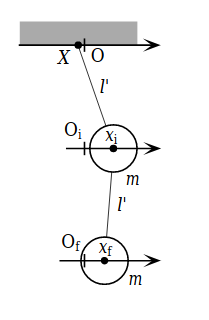
図１：ダンピングなしの二段振り子の力学モデル。新井さんの修論の図4.1を転載。

変数を定義する。

In [10]:
x2, f2 = dynamicsymbols("x2 f2")
m2, c2, k2 = symbols("m2 c2 k2")
l2, g = symbols("l2 g")
w2 = symbols("w2")

In [11]:
p2 = Point("p2") 
v2 = x2.diff(t)
p2.set_vel(N, v2*N.x)
pa2 = Particle("pa2", p2, m2)

ポテンシャルエネルギーを定義する。

In [12]:
pa2.potential_energy = k2*(x2-X)**2/2 + k1*(x1-x2)**2/2
pa1.potential_energy = k1*(x2-x1)**2/2

外力を定義する。

In [13]:
F = c1*(v1)**2/2 + c2*(v2)**2/2 
fc1 = -F.diff(v1)
fc2 = -F.diff(v2)
fl = [(p1, (f1 + fc1)*N.x), (p2, (f2 + fc2)*N.x)] # with damping

ラグランジアンを定義し、運動方程式をもとめる。

In [14]:
L = Lagrangian(N, pa1, pa2)
q = Matrix([x1,x2])
LM = LagrangesMethod(L, q, forcelist=fl, frame=N)
eq = LM.form_lagranges_equations()

状態方程式として表現する。


In [15]:
As, Bs, u = LM.linearize(q_ind=q, qd_ind=q.diff(t), A_and_B=True)#,simplify=True)
eq

⎡          c₁⋅x₁̇ + k₁⋅(2⋅x₁ - 2⋅x₂) + m₁⋅x₁̈ - f₁          ⎤
⎢                                                         ⎥
⎢                            k₂⋅(-2⋅X + 2⋅x₂)             ⎥
⎢c₂⋅x₂̇ + k₁⋅(-2⋅x₁ + 2⋅x₂) + ──────────────── + m₂⋅x₂̈ - f₂⎥
⎣                                   2                     ⎦

状態方程式の行列と入力ベクトルは以下の通り。

In [16]:
As,Bs,u

⎛⎡  0         0        1     0  ⎤  ⎡0   0   0 ⎤      ⎞
⎜⎢                              ⎥  ⎢          ⎥      ⎟
⎜⎢  0         0        0     1  ⎥  ⎢0   0   0 ⎥      ⎟
⎜⎢                              ⎥  ⎢          ⎥  ⎡X ⎤⎟
⎜⎢-2⋅k₁      2⋅k₁     -c₁       ⎥  ⎢    1     ⎥  ⎢  ⎥⎟
⎜⎢──────     ────     ────   0  ⎥, ⎢0   ──  0 ⎥, ⎢f₁⎥⎟
⎜⎢  m₁        m₁       m₁       ⎥  ⎢    m₁    ⎥  ⎢  ⎥⎟
⎜⎢                              ⎥  ⎢          ⎥  ⎣f₂⎦⎟
⎜⎢ 2⋅k₁   -2⋅k₁ - k₂        -c₂ ⎥  ⎢k₂      1 ⎥      ⎟
⎜⎢ ────   ──────────   0    ────⎥  ⎢──  0   ──⎥      ⎟
⎝⎣  m₂        m₂             m₂ ⎦  ⎣m₂      m₂⎦      ⎠

実際の値を代入する。

In [25]:
m1n = 1. #kg
m2n = 1. #kg
c1n = 0.5 #
c2n = 0.5 #
l1n = 0.25
l2n = 0.5 - l1n
w1n = (gn/l1n)**(1/2)
w2n = (gn/l2n)**(1/2)
k1n = w1n**2*m1n
k2n = w2n**2*m2n
#k1n = 4 #
#k2n = 4 #

#As_func = lambdify((m1, m2, c1, c2, k1, k2), As, modules="numpy")
#Bs_func = lambdify((m1, m2, k1, k2), Bs, modules="numpy")

#A0 = As_func(m1n, m2n, c1n, c2n, k1n, k2n)
#B0 = Bs_func(m1n, m2n, k1n, k2n)

As_func = lambdify((m1, c1, k1, m2, c2, k2), As, modules="numpy")
Bs_func = lambdify((m1, k1, m2, k2), Bs, modules="numpy")

A0 = As_func(m1n, c1n, k1n, m2n, c2n, k2n)
B0 = Bs_func(m1n, k1n, m2n, k2n)
A0
B0

array([[ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ],
       [39.2,  0. ,  1. ]])

状態方程式から伝達関数を求める。そのために、出力項を定義する。

状態変数すべてをとりだしたいので、Cは単位行列にする。
入力は出力に取り出さないのでDはゼロ。

In [26]:
C = np.eye(4)
D = np.zeros((4,3))

Python のControlパッケージをつかって、ABCD行列から求める。

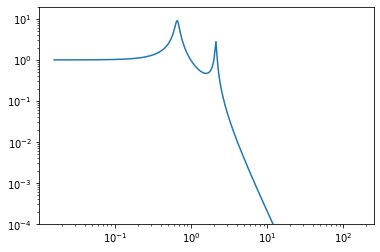

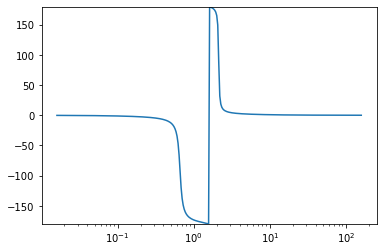

In [28]:
import matplotlib.pyplot as plt
sys = control.ss(A0,B0,C,D)
mag,phase,omega = sys.freqresp(np.logspace(-1,3,300))
plt.figure()

# in  0: X
#     1: f1
#     2: f2
# out 0: x1
#     1: x2
#     2: v1
#     3: v2

_in,_out = 0,0 
mag = mag[_out][_in]
phase = phase[_out][_in]
freq = omega/(2.0*np.pi)
plt.loglog(freq,mag)
plt.ylim(1e-4,2e1)
plt.figure()
plt.semilogx(freq, np.rad2deg(phase))  
plt.ylim(-180,180)
plt.show()

Text(0.5, 0, 'Frequency [Hz]')

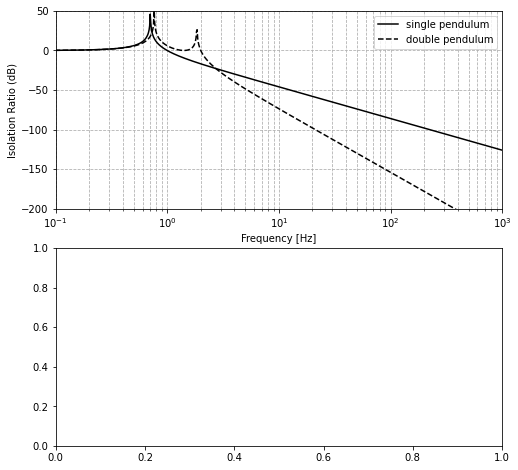

In [24]:
import numpy as np
import matplotlib.pyplot as plt

freq = np.logspace(-2,3,1000)
w = 2.0*np.pi*freq
g = 9.8 # m/s/s
l = 0.5 # m
w0 = np.sqrt(g/l)
w0_ = np.sqrt(g/(l/2))
_single_seis2tm = lambda w,w0: w0**2/(w0**2-w**2)
_double_seis2tm = lambda w,w0: 2*w0**4/(w**4-4*w0**2*w**2+2*w0**4)
_double_seis2im = lambda w,w0: 2*(w0**4-w0**2*w**2)/(w**4-4*w0**2*w**2+2*w**4)
_db = lambda mag: 20*np.log10(mag)
single_seis2tm = np.vectorize(_single_seis2tm, otypes=[float])
double_seis2tm = np.vectorize(_double_seis2tm, otypes=[float])
db = np.vectorize(_db,otypes=[float])

seis2tm_single = single_seis2tm(w,w0)
seis2tm_double = double_seis2tm(w,w0_)
fig, ax = plt.subplots(2,1,figsize=(8,8))

ax[0].semilogx(freq,db(np.abs(seis2tm_single)),'k-',label='single pendulum')
ax[0].semilogx(freq,db(np.abs(seis2tm_double)),'k--',label='double pendulum')
ax[0].set_ylim(-200,50)
ax[0].set_xlim(1e-1,1e3)
ax[0].grid(b=True, which='both', linestyle='--')
ax[0].legend()
ax[0].set_ylabel('Isolation Ratio (dB)')
ax[0].set_xlabel('Frequency [Hz]')
#plt.savefig('double_nodamp.png')

## フレキシブルダンピングあり

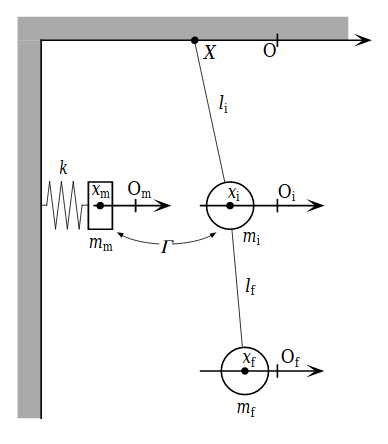

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
freq = np.logspace(-2,3,1000)
w = 2.0*np.pi*freq
li = 0.25 # m
lf = 0.5-li # m
km = 600
g = 9.8 # m/s/s
mi,mf = 1,1.034 #kg
ki = (g/li)*(mi+mf)
kf = (g/lf)*mf
mm = 0.5 #kg
gamma = 1
s = 1j*w
a = 0
def H(w):
    s = 1j*w
    _H = np.array([[mi*s**2+ki+kf+s*(gamma+a),        -kf,           -s*gamma],
                   [-kf                  , mf*s**2+kf+a*s,                  0],
                   [-s*gamma             ,          0, mm*s**2+km+s*(gamma+a)]])
    return np.linalg.inv(_H)

_double_seis2tm_damp = lambda w: H(w)[1][0]*ki + H(w)[1][1]*0 + H(w)[1][2]*km
double_seis2tm_damp = np.vectorize(_double_seis2tm_damp, otypes=[float])
_db = lambda mag: 20*np.log10(mag)

db = np.vectorize(_db,otypes=[float])

seis2tm_double_damp = double_seis2tm_damp(w)

fig, ax = plt.subplots(2,1,figsize=(8,8))
ax[0].semilogx(freq,db(np.abs(seis2tm_double)),'k--',label='double pendulum')
ax[0].semilogx(freq,db(np.abs(seis2tm_double_damp)),'r--',label='double pendulum damp')
ax[0].set_ylim(-150,50)
ax[0].set_xlim(1e-1,1e3)
ax[0].grid(b=True, which='both', linestyle='--')
ax[0].legend()
ax[0].set_ylabel('Isolation Ratio (dB)')
ax[0].set_xlabel('Frequency [Hz]')
#plt.savefig('double_damp.png')
#plt.close()

# 参考文献
[1] 新井修論